In [14]:
from CONTINUED.utils import *
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import cv2
from tqdm import tqdm
import warnings
from pdf2image import convert_from_path
from PIL import Image
from IPython.display import display
mpl.use('Agg')  # 使用非交互式后端
warnings.filterwarnings("ignore")

In [7]:
def pdf2png(pdf_file):

    # 将 PDF 转换为图像列表
    pages = convert_from_path(pdf_file)
    
    # 选择第一页（或你需要的页面）
    pil_image = pages[0]
    
    # 将 PIL 图像转换为 numpy 数组
    img = np.array(pil_image)
    
    return img

## 	The sample informations and the parameters

In [3]:
sample = 'ST87_20210331'
to_dir = f'/data/yuchen_data/desi_scripts/result/{sample}'

# raw file path
desi_lm_file = '/data/yuchen_data/desi_scripts/data/20210331 negST87B-5 12um-tangzh Analyte 1 5000 lockmass.txt'
desi_unlm_file = '/data/yuchen_data/desi_scripts/data/20210331 negST87B-5 12um-tangzh Analyte 1 5000.txt'

# parameters for tissue detection
mz_tissue = '788.5479'  #
mz_tissue_type = 'unlm' #
thresh = 500       #

# parameters for clustering
resolution = 1     #

# parameters for remove noise
num = 90
bg_percent = 0.5

# paremeters for identify borderline
threshold_border = 10
border_dir = f'{to_dir}/5.cluster.borderline'

# colormap
nodes = [0.0, 0.05, 0.3, 1.0]
cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, ["#EAE7CC","#EAE7CC","#FD1593","#FD1593"])))
col16 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324',
        '#fffac8', '#800000', '#aaffc3', '#808000', "#05B9E2","#EF7A6D","#397A7F","#ba5557","#C76DA2","#2878B5","#7d9221","#BB9727","#8983BF","#845a2a","#B03060","#54B345","#C497B2","#96CCCB","#AABAC2","#ffae3b"]

check_makedir(to_dir)
check_makedir(border_dir)

## Step1: Load DESI raw data

In [4]:
df_desi_lm, df_desi_unlm = load_raw_desi_data(desi_lm_file, desi_unlm_file)

In [5]:
# The row indicates the bin id. The columns contains the X and Y position, as well as the m/z
df_desi_lm.head()

,x,y,554.2598,555.2624,255.2321,283.2630,617.2543,639.2358,556.2648,1109.5251,...,120.8259,1008.1007,606.3760,544.8434,963.6295,953.6077,669.2527,866.6569,1139.9606,905.9409
Bin_0,9.90,-5.5,75510.0,23677.0,44705.0,31584.0,5414.0,4032.0,5316.0,2169.0,...,0.0,58.0,59.0,47.0,0.0,43.0,41.0,37.0,64.0,0.0
Bin_1,9.95,-5.5,249229.0,69484.0,135958.0,97956.0,9808.0,10583.0,15232.0,4541.0,...,107.0,0.0,0.0,0.0,11.0,28.0,48.0,43.0,0.0,63.0
Bin_2,10.00,-5.5,457247.0,123968.0,242046.0,179161.0,13512.0,16962.0,27581.0,7991.0,...,77.0,0.0,59.0,0.0,101.0,0.0,95.0,0.0,0.0,74.0
Bin_3,10.05,-5.5,618506.0,168205.0,337813.0,245342.0,17411.0,18315.0,36314.0,9437.0,...,0.0,0.0,126.0,26.0,0.0,0.0,80.0,0.0,166.0,115.0
Bin_4,10.10,-5.5,857867.0,222052.0,464197.0,330602.0,21145.0,22537.0,47566.0,13627.0,...,117.0,0.0,260.0,0.0,0.0,0.0,73.0,61.0,75.0,61.0


## Step2: Tissue detection
### We first check the selected m/z(mz_tissue) can indicate the real tissue.


In [18]:
check_tissue_mz(mz_tissue_type, mz_tissue, thresh, df_desi_unlm, df_desi_lm, cmap, to_dir)

### check_tissue_mz will generate two pdf represents the raw and binarized signal of the selected m/z

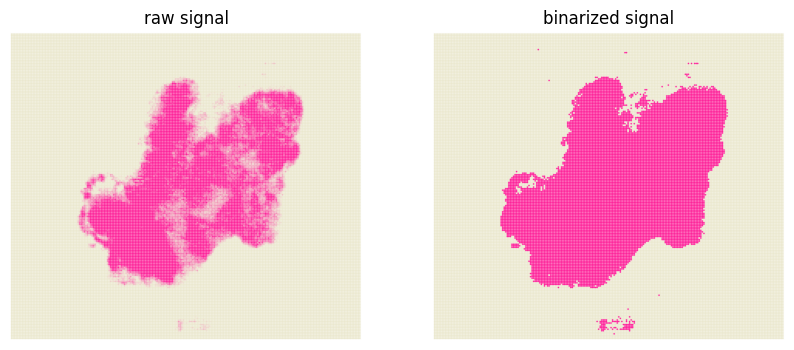

In [19]:
img1 = pdf2png(f'{to_dir}/1.1.check.tissue_mz.pdf')
img2 = pdf2png(f'{to_dir}/1.2.check.tissue_mz.thresh.pdf')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1)
ax[0].set_title('raw signal')
ax[0].axis('off')

ax[1].imshow(img2)
ax[1].set_title('binarized signal')
ax[1].axis('off')

display(fig)

### Next, we are going to identify the tissue region

In [20]:
if mz_tissue_type == 'unlm':
    tissue_mask = tissue_detection(df_desi_unlm, str(mz_tissue), to_dir, thresh=thresh, otsu=False, dilate_size=2, tissue_erode_size=5)
else:
    tissue_mask = tissue_detection(df_desi_lm, str(mz_tissue), to_dir, thresh=thresh, otsu=False, dilate_size=2, tissue_erode_size=5)

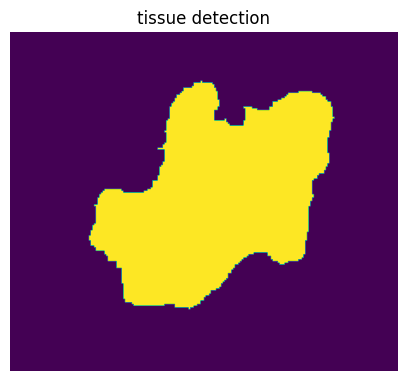

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.flipud(tissue_mask))
ax.set_title('tissue detection')
ax.axis('off')
display(fig)

## Step 3: remove background and extract tissue signal
### Because the DESI data are noisy, the noise signal will affects the accuracy of subsequent analysis, so, in this step, we are going to filter some signal

In [26]:
noise_signal_unlm, true_signal_unlm, df_desi_unlm_filter = remove_noise_signal(df_desi_unlm, tissue_mask, num, bg_percent)
noise_signal_lm, true_signal_lm, df_desi_lm_filter = remove_noise_signal(df_desi_lm, tissue_mask, num, bg_percent)

100%|██████████| 3000/3000 [00:22<00:00, 135.64it/s]


In [27]:
print(f'In the unlock mass matrux, the raw signal number is {df_desi_unlm.shape[1] - 2}, the retained signal number is {df_desi_unlm_filter.shape[1] - 2}')
print(f'In the lock mass matrux, the raw signal number is {df_desi_lm.shape[1] - 2}, the retained signal number is {df_desi_lm_filter.shape[1] - 2}')

In the unlock mass matrux, the raw signal number is 3000, the retained signal number is 480
In the lock mass matrux, the raw signal number is 3000, the retained signal number is 517


### we can save the retained signal matrix

In [28]:
# save true signal matrix
df_desi_unlm_filter.columns = ['x', 'y'] + [f'mz_{x}' for x in df_desi_unlm_filter.columns[2: ]]
df_desi_lm_filter.columns = ['x', 'y'] + [f'mz_{x}' for x in df_desi_lm_filter.columns[2: ]]
# extract tissue signal
df_desi_unlm_final = get_final_matrix(df_desi_unlm_filter, tissue_mask)
df_desi_lm_final = get_final_matrix(df_desi_lm_filter, tissue_mask)
df_desi_unlm_final.to_csv(f'{to_dir}/3.result.true.signal.unlm.txt', sep='\t')
df_desi_lm_final.to_csv(f'{to_dir}/3.result.true.signal.lm.txt', sep='\t')

## 	Step 4: create annadata object and clustering
#### This step will generate and save the annadata object in the folder "todir"
#### The clustering result also saved in the file "4.clustering.lm.pdf" and "4.clustering.unlm.pdf"

In [29]:
adata_lm = create_desi_obj(df_desi_lm_final)
adata_lm = desi_clustering(adata_lm, resolution, f'{to_dir}/4.clustering.lm', col16)
adata_lm.write_h5ad(f'{to_dir}/4.lm_final.h5ad')
adata_unlm = create_desi_obj(df_desi_unlm_final)
adata_unlm = desi_clustering(adata_unlm, resolution, f'{to_dir}/4.clustering.unlm', col16)
adata_unlm.write_h5ad(f'{to_dir}/4.unlm_final.h5ad')

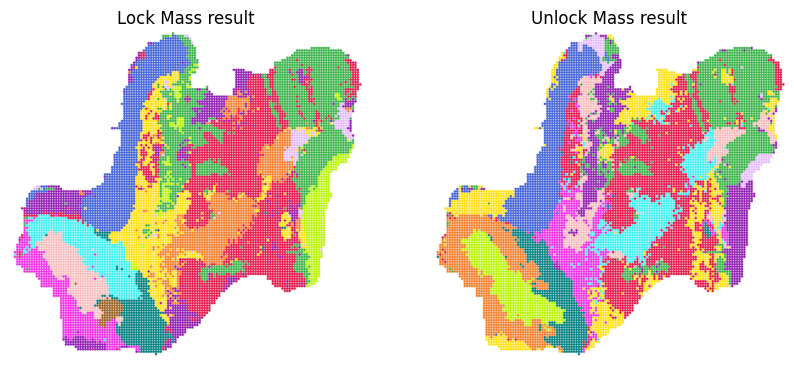

In [30]:
# Now, we can visualize the clustering result
img1 = pdf2png(f'{to_dir}/4.clustering.lm.pdf')
img2 = pdf2png(f'{to_dir}/4.clustering.unlm.pdf')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1)
ax[0].set_title('Lock Mass result')
ax[0].axis('off')

ax[1].imshow(img2)
ax[1].set_title('Unlock Mass result')
ax[1].axis('off')

display(fig)

## Step 5: plot the cluster borderline for visualization
#### This step will generate the borderline for each cluster, then we can overlay the image for visualization

In [31]:
prefix_lm = f'{border_dir}/lm'
plot_cluster_border(adata_lm, prefix_lm, threshold_border, col16)

prefix_unlm = f'{border_dir}/unlm'
plot_cluster_border(adata_unlm, prefix_unlm, threshold_border, col16)

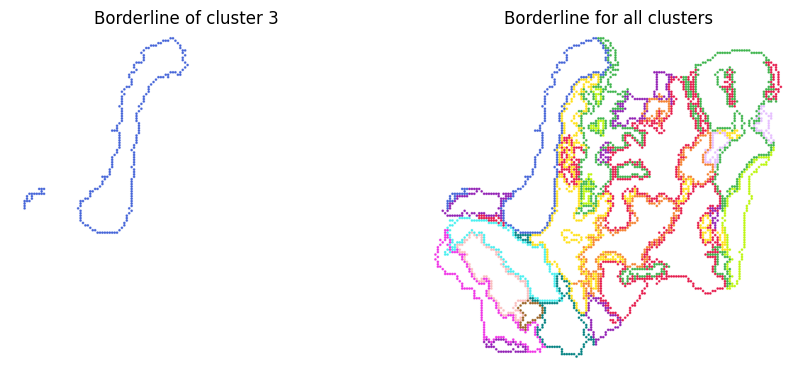

In [36]:
# Now, we can visualize the clustering result
img1 = pdf2png(f'{border_dir}/lm.cluster.3.pdf')
img2 = pdf2png(f'{border_dir}/lm.cluster.merge.pdf')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1)
ax[0].set_title('Borderline of cluster 3')
ax[0].axis('off')

ax[1].imshow(img2)
ax[1].set_title('Borderline for all clusters')
ax[1].axis('off')

display(fig)